# Playground

In [1]:
import glob
import ctypes

import matplotlib.pyplot as plt
import numpy as np

import radarkit

from style import context_properties

In [2]:
files = sorted(glob.glob('data/*.rkr'))
file = files[-1]

print(f'Selected file {file}')

Selected file data/PX-20230130-173637.867.rkr


In [3]:
# radarkit.init_workspace(cores=4)

rkid = radarkit.open(file)

In [4]:
riq, ciq = rkid.read()

Estimated number of pulses = 29,458    gateCount = 2,659   downSampledGateCount = 1,092


100%|███████████████████████████████████████████████████████████████████████████████████|00:01<00:00


In [5]:
ciq.shape

(29458, 2, 1092)

# AScope

- Compute the average power of the last `count` raw pulses
- Compute the average power of the last `count` compressed pulses
- Add a `tiny` value to avoid log of 0

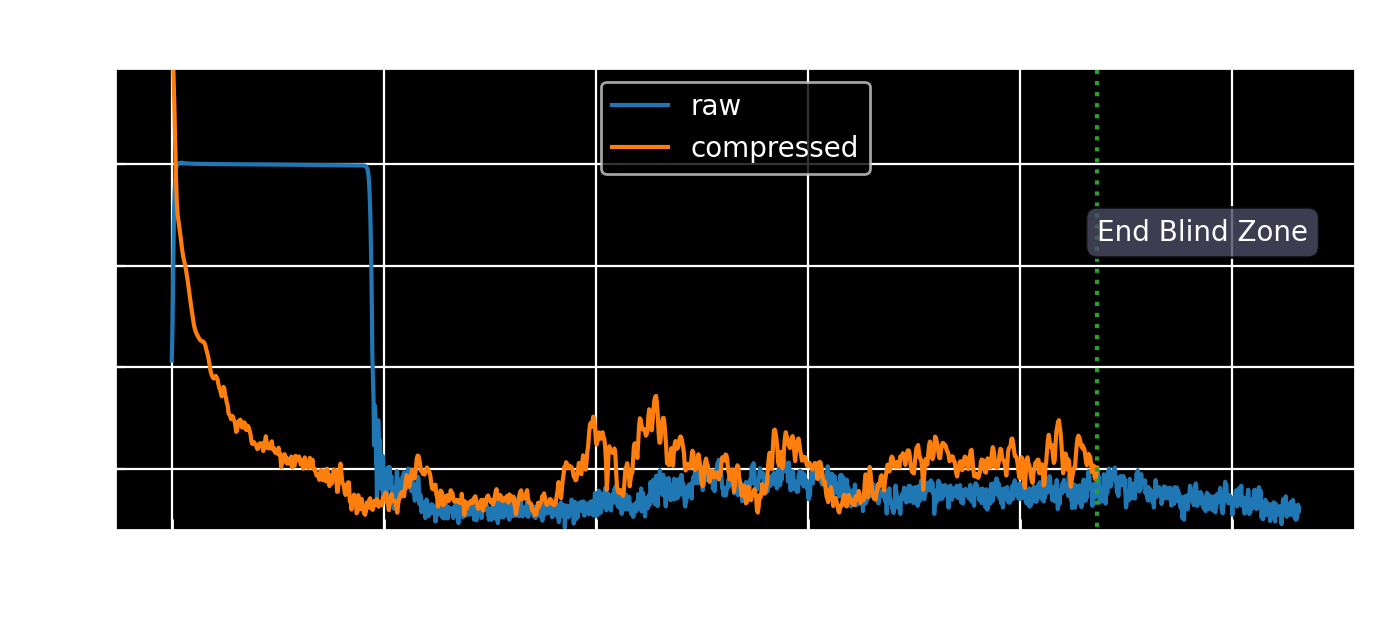

In [6]:
tiny = 1.0e-3

count = 20
r = np.mean(np.abs(riq[-count:, 0, :]) ** 2, axis=0)
c = np.mean(np.abs(ciq[-count:, 0, :]) ** 2, axis=0)

xr = np.arange(riq.shape[2])
xc = np.arange(ciq.shape[2]) * rkid.desc.pulseToRayRatio
xb = np.array([1, 1]) * xc[-1]

yr = 10 * np.log10(r + tiny)   # Add a small number to avoid log of 0
yc = 10 * np.log10(c + tiny)   # Add a small number to avoid log of 0

with plt.rc_context(context_properties):
    plt.figure(figsize=(8, 3), dpi=200)
    plt.plot(xr, yr, label='raw')
    plt.plot(xc, yc, label='compressed')
    plt.plot(xb, [0, 100], ':')
    plt.text(xb[0], 65, 'End Blind Zone', bbox={
        'boxstyle': 'round,pad=0.4',
        'facecolor': (0.3, 0.3, 0.4, 0.85),
        'alpha': 0.8
    })
    plt.ylim(8, 99)
    plt.grid()
    plt.legend()
    plt.xlabel('Range Gates')
    plt.ylabel('Power (dB-ADU)')
    plt.title('A-Scope', fontweight='bold')
    plt.show()

# B-Scope

- Select a `count` for number of pulses to compute a radial
- Extract up to `rayCount * count` pulses
- Reindex the array to (gateCount, rayCount, count)
- Compute power, average over the last axis count

In [7]:
count = 80
rayCount = ciq.shape[0] // count
gateCount = ciq.shape[2]
n = rayCount * count
x = np.reshape(ciq[:n, 0, :], (rayCount, count, -1))
x = np.transpose(x, (2, 0, 1))
p = np.mean(np.abs(x) ** 2, axis=2)

with plt.rc_context(context_properties):
    plt.figure(figsize=(8, 4), dpi=200)
    plt.pcolormesh(10 * np.log10(p + tiny), cmap='viridis', vmin=8, vmax=43)
    plt.xlabel('Ray Index')
    plt.ylabel('Gate Index')
    plt.title('B-Scope', fontweight='bold')
    cb = plt.colorbar()
    cb.set_label('dB-ADU')
    # plt.show()

In [8]:
radarkit.free()